# Projet Apprentissage Profond

#Chargement/Préparation des données

In [28]:
!git clone https://github.com/Spiroxx/projet_ap.git

fatal: destination path 'projet_ap' already exists and is not an empty directory.


In [29]:
import PIL
from PIL import Image
import csv
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

## Préparation des données

Le code ci-dessous permet de charger les données et les formater pour la classification. Prenez le temps de regarder un peu le format des labels $y$.
Notez que les images sont rendues carrées lors du chargement.

In [30]:
# Lecture du CSV contenant les informations relatives à la base de données
dataset = []
with open('projet_ap/data.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=' ', quotechar='|')
	for row in filereader:
		data = row[0].split(',')
		if data[0] != 'DATA' and  data[0] != 'TEST':
			box = [float(data[2]), float(data[3]), float(data[4]), float(data[5])]
			new_entry = {'type': data[0], 'path': data[1], 'shape': [float(data[6]), float(data[7])], 'box': box}
			dataset.append(new_entry)

# Nombre de classes de la base de données et intitulé des classes
class_labels = ['ball']
num_classes = 1

# Extraction des données d'apprentissage et de test
dataset_train = [item for item in dataset if item['type']=='TRAIN']
dataset_test = [item for item in dataset if item['type']=='TEST']

#print(class_labels)

In [31]:
def build_localization_tensors(image_size, dataset, num_classes):
  # Préparation des structures de données pour x et y
  x = np.zeros((len(dataset), image_size, image_size, 3))
  y = np.empty((len(dataset), num_classes + 5)) # 1 + 4 + num_classes : présence / boîte englobante / classes

  # Compteur de parcours du dataset
  i = 0

  for item in dataset:
    # Lecture de l'image
    img = Image.open('projet_ap/data/' + item['path'])
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.Resampling.LANCZOS)
    # Remplissage de la variable x
    x[i] = np.asarray(img)

    y[i, 0] = 1 # Un objet est toujours présent !

    # Coordonnées de boîte englobante
    img_shape = item['shape']
    box = item['box']
    bx = (box[0] + (box[2] - box[0]))/img_shape[0]
    by = (box[1] + (box[3] - box[1]))/img_shape[1]
    bw = (box[2] - box[0])/img_shape[0]
    bh = (box[3] - box[1])/img_shape[1]
    y[i, 1] = bx
    y[i, 2] = by
    y[i, 3] = bw
    y[i, 4] = bh

    # Probabilités de classe, sous la forme d'une one-hot vector
    #label = class_labels.index(item['specie'])
    #classes_probabilities = keras.utils.to_categorical(label, num_classes=num_classes)
    #y[i, 5:] = classes_probabilities

    i = i+1

  return x, y

Séparation des données d'entraînement pour extraire un ensemble de validation, et pré-traitement des données.

In [32]:
from sklearn.model_selection import train_test_split


# Pour la suite du TP on considèrera des images de taille 64x64x3
# Augmenter cette valeur donnerait de meilleurs résultats mais nécessiterait des calculs plus long.
IMAGE_SIZE = 64

# Lecture des données d'entraînement et de test
x, y = build_localization_tensors(IMAGE_SIZE, dataset_train, 1)
x_test, y_test = build_localization_tensors(IMAGE_SIZE, dataset_test, 1)

#Extraction d'un ensemble de validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.10, random_state=42)

# Pour améliorer l'entraînement, on peut centrer-réduire les coordonnées des bounding boxes...
y_std = np.std(y_train, axis=0)
y_mean = np.mean(y_train, axis=0)
y_train[...,1:5] = (y_train[...,1:5] - y_mean[1:5])/y_std[1:5]
y_val[...,1:5] = (y_val[...,1:5] - y_mean[1:5])/y_std[1:5]
y_test[...,1:5] = (y_test[...,1:5] - y_mean[1:5])/y_std[1:5]

# ... et normaliser les valeurs de couleur
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

Visualisation des données et labels

Box raw values: [-1.18300035 -0.24461165 -0.56265133 -0.29404251]
Dénormalisées: 14.449826989619378 31.778546712802765 1.743944636678206 3.764705882352949


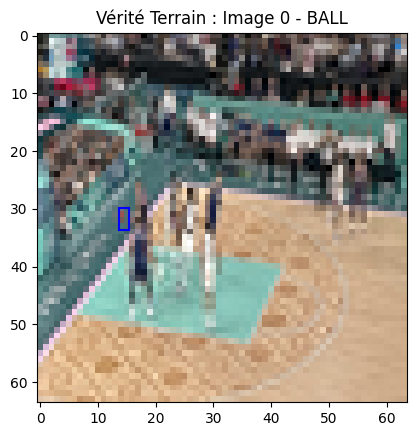

Box raw values: [-1.28023675  1.04546349 -0.19825805 -0.48917492]
Dénormalisées: 13.079584775086506 45.34256055363322 2.117647058823532 3.432525951557094


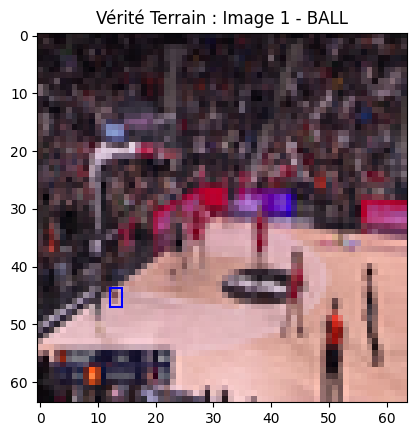

Box raw values: [ 0.2070383   0.81904214 -0.62338354 -0.29404251]
Dénormalisées: 34.03806228373702 42.96193771626297 1.6816608996539741 3.7647058823529327


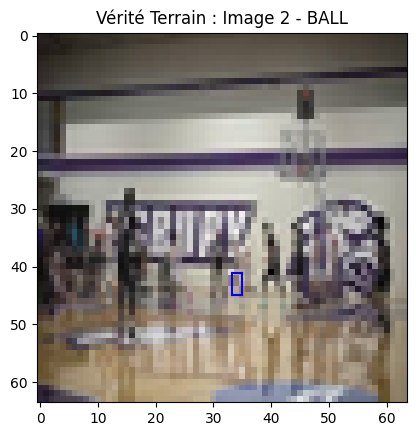

Box raw values: [ 1.16835279  0.48730853 -0.80558018 -1.1396163 ]
Dénormalisées: 47.58477508650518 39.47404844290657 1.494809688581313 2.325259515570933


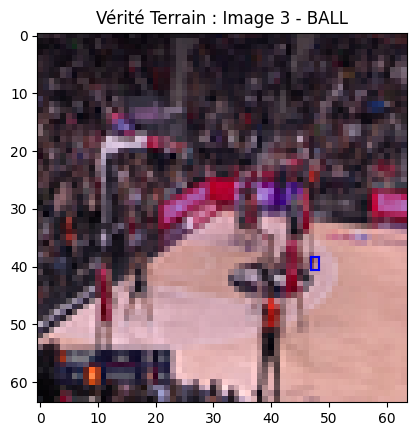

Box raw values: [ 0.03908451 -0.16562746 -0.13752584 -0.22899837]
Dénormalisées: 31.671280276816606 32.60899653979239 2.179930795847747 3.8754325259515605


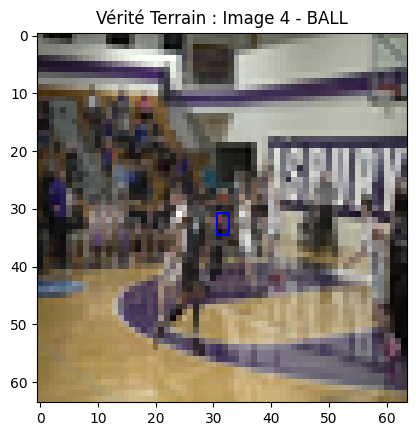

Box raw values: [ 1.50205046 -0.19195552  0.955654    1.2670168 ]
Dénormalisées: 52.28719723183391 32.332179930795846 3.3010380622837374 6.422145328719721


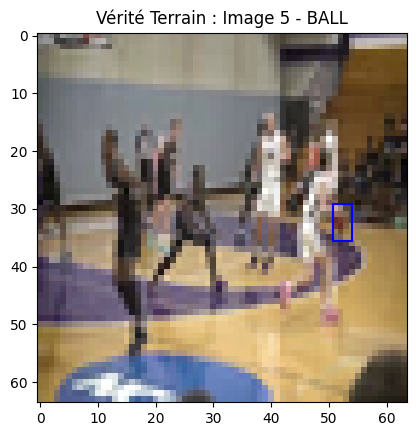

Box raw values: [ 0.31753422 -0.73957925 -0.01606141 -0.03386596]
Dénormalisées: 35.59515570934256 26.574394463667826 2.3044982698961975 4.2076124567474125


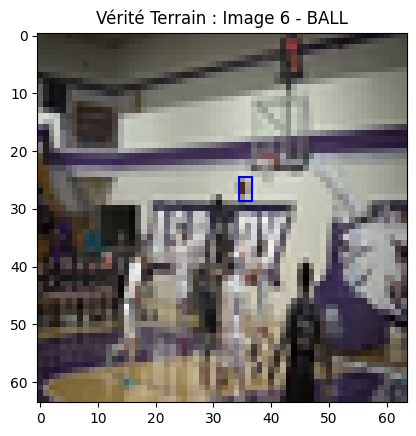

Box raw values: [-0.31229251  1.8721647  -0.19825805 -0.68430734]
Dénormalisées: 26.719723183390997 54.034602076124564 2.117647058823521 3.1003460207612417


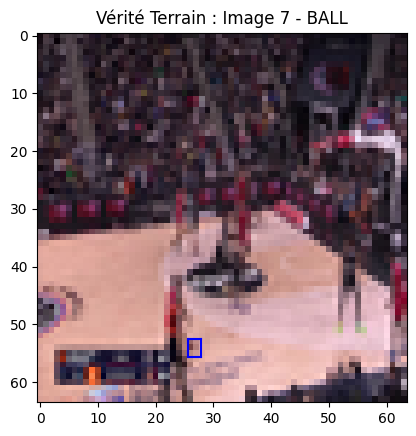

Box raw values: [-0.67471912  0.65054253 -0.68411576 -0.68430734]
Dénormalisées: 21.61245674740483 41.19031141868508 1.6193771626297613 3.1003460207612283


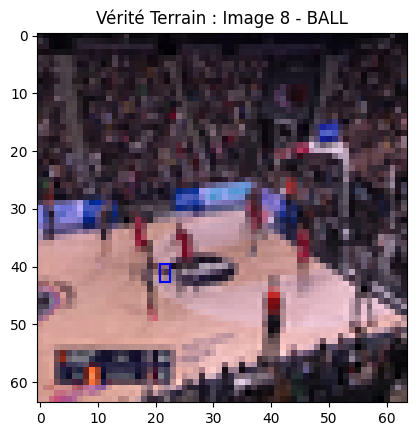

Box raw values: [ 1.47553144  0.82430775 -0.38045469 -0.35908665]
Dénormalisées: 51.913494809688586 43.01730103806228 1.9307958477508766 3.653979238754329


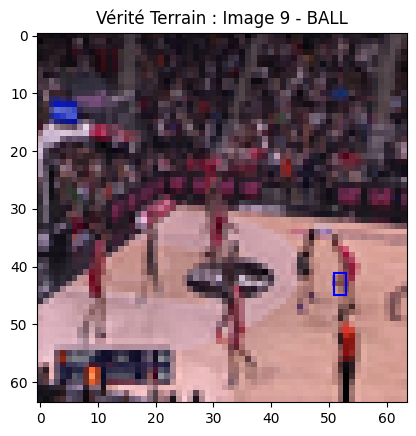

In [33]:
# Si seuls x et y sont indiqués, on tire au hasard un numéro d'image et on affiche le label y associé  à l'image
# Si un 2e y, nommé y_pred, est indiqué, alors les deux labels sont affichés côte à côte, afin de pouvoir les comparer
# Enfin on peut également indiquer l'id de l'image que l'on souhaite visualiser.

def print_data_localisation(x, y, y_pred=[], id=None, image_size=IMAGE_SIZE):
  if id==None:
    # Tirage aléatoire d'une image dans la base
    num_img = np.random.randint(x.shape[0]-1)
  else:
    num_img = id


  img = x[num_img]
  lab = y[num_img]

  colors = ["blue"] # Différentes couleurs pour les différentes classes
  classes = ['BALL']

  if np.any(y_pred):
    plt.subplot(1, 2, 1)

  # Affichage de l'image
  plt.imshow(img)
  # Détermination de la classe
  class_id = np.argmax(lab[5:])

  # Détermination des coordonnées de la boîte englobante dans le repère image
  ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
  ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
  width = (lab[3]*y_std[3] + y_mean[3]) * image_size
  height = (lab[4]*y_std[4] + y_mean[4]) * image_size
  print("Box raw values:", lab[1:5])
  print("Dénormalisées:", ax, ay, width, height)
  #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
  # Détermination des extrema de la boîte englobante
  p_x = [ax-width/2, ax+width/2]
  p_y = [ay-height/2, ay+height/2]
  # Affichage de la boîte englobante, dans la bonne couleur
  plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
  plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
  plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
  plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
  plt.title("Vérité Terrain : Image {} - {}".format(num_img, classes[class_id]))

  if np.any(y_pred):
    plt.subplot(1, 2, 2)
    # Affichage de l'image
    plt.imshow(img)
    lab = y_pred[num_img]
    # Détermination de la classe
    class_id = np.argmax(lab[5:])

    # Détermination des coordonnées de la boîte englobante dans le repère image
    ax = (lab[1]*y_std[1] + y_mean[1]) * image_size
    ay = (lab[2]*y_std[2] + y_mean[2]) * image_size
    width = (lab[3]*y_std[3] + y_mean[3]) * image_size
    height = (lab[4]*y_std[4] + y_mean[4]) * image_size
    #print("x: {}, y: {}, w: {}, h:{}".format(ax,ay,width, height))
    # Détermination des extrema de la boîte englobante
    p_x = [ax-width/2, ax+width/2]
    p_y = [ay-height/2, ay+height/2]
    # Affichage de la boîte englobante, dans la bonne couleur
    plt.plot([p_x[0], p_x[0]],p_y,color=colors[class_id])
    plt.plot([p_x[1], p_x[1]],p_y,color=colors[class_id])
    plt.plot(p_x,[p_y[0],p_y[0]],color=colors[class_id])
    plt.plot(p_x,[p_y[1],p_y[1]],color=colors[class_id])
    plt.title("Prédiction : Image {} - {}".format(num_img, classes[class_id]))

  plt.show()

for i in range(10):#x.shape[0]):
    print_data_localisation(x_train, y_train, image_size=IMAGE_SIZE, id=i)


# Fonctions utiles

Calcul de l'intersection sur union.

$$ IoU (R_1, R_2) = \frac{\mathcal{A} (R_1 \cap R_2)}{\mathcal{A} (R_1 \cup R_2)} = \frac{\mathcal{A} (R_1 \cap R_2)}{\mathcal{A} (R_1) + \mathcal{A} (R_2) -  \mathcal{A} (R_1 \cap R_2)} $$

In [34]:
def intersection_sur_union(box1, box2):
  """
  Calcul de l'intersection sur union entre deux rectangles box1 et box2

  Arguments:
  box1, box2 -- les coordonnées des deux rectangles, chacun sous la forme [cx, cy, w, h]
                où (cx, cy) désigne les coordonnées du centre du rectangle,
                w sa largeur et h sa hauteur

  Retourne :
  iou -- la valeur d'intersection sur union entre les deux rectangles
  """
  x1,y1 = (box1[0] - box1[2]/2,box1[1] - box1[3]/2)
  x2,y2 = (box1[0] + box1[2]/2,box1[1] + box1[3]/2)
  x3,y3 = (box2[0] - box2[2]/2,box2[1] - box2[3]/2)
  x4,y4 = (box2[0] + box2[2]/2,box2[1] + box2[3]/2)

  a1 = box1[2] * box1[3]
  a2 = box2[2] * box2[3]
  wi = abs(min(x2,x4) - max(x1,x3))
  hi = abs(max(y1,y3) - min(y2,y4))

  ai = wi * hi
  au = a1 + a2 - ai

  return ai/au

On va maintenant calculer les différentes métriques :

$$ P = \frac{TP}{TP + FP} $$

$$ R = \frac{TP}{TP + FN} $$

$$ F1 = \frac{2 * P * R}{P + R} $$

où $TP$ désigne le nombre de vrais positifs, $FP$ le nombre de faux positifs, $FN$ le nombre de faux négatifs, $P$ la précision, $R$ le rappel et $F1$ le F1-score.

On considère souvent qu'une détection est correcte si la classification est valide et que l'intersection sur union entre vérité terrain et prédiction est supérieure à 0.5 (on utilisera un seuil modifiable *iou_thres*).

In [35]:
# On considère souvent qu'une détection est correcte si la classification est valide et que
# l'intersection sur union entre vérité terrain et prédiction est supérieure à 0.5
def global_accuracy(y_true, y_pred, iou_thres=0.4):
  """
  Calcul, pour chaque classe de la précision, du rappel et du F1-score ainsi
  que du pourcentage global de bonnes détections.

  Arguments:
  y_true -- les labels de la vérité terrain, de dimension (M, 1+4+N) où M désigne
          le nombre d'éléments du dataset et N le nombre de classes (11 dans notre cas)
  y_pred -- les labels prédits par un modèle, de dimension (M, 1+4+N)
  iou_thres -- seuil d'intersection sur union entre une boîte "vérité-terrain" et
              une boite prédite au-dessus duquel on considère que la prédiction est correcte

  Retourne :
  class_res -- liste de longueur N contenant des dictionnaires sous la forme
            {"Précision": p, "Rappel": r, "F-score": f} résumant les métriques
            précision, rappel et F1-score pour chacune des classes.
  accuracy -- pourcentage global de bonnes détections
  """
  # Initialisation des métriques : nombre de vrais positifs (TP), faux positifs (FP)
  # et faux négatifs (FN) pour chaque classe
  class_metrics = []
  for i in range(num_classes):
    class_metrics.append({'TP': 0, 'FP': 0, 'FN': 0})

  # Nombres de détections correctes et de détections incorrectes
  total_correct_detections = 0
  total_incorrect_detections = 0
  for i in range(y_true.shape[0]):
    # Labels vérité-terrain et prédits
    groundtruth_label = np.argmax(y_true[i,5:])
    predicted_label = np.argmax(y_pred[i,5:])

    # Coordonnées de boîtes englobantes réelles et prédites
    bx_true = (y_true[i,1]*y_std[1] + y_mean[1])
    by_true = (y_true[i,2]*y_std[2] + y_mean[2])
    bw_true = (y_true[i,3]*y_std[3] + y_mean[3])
    bh_true = (y_true[i,4]*y_std[4] + y_mean[4])
    bx_pred = (y_pred[i,1]*y_std[1] + y_mean[1])
    by_pred = (y_pred[i,2]*y_std[2] + y_mean[2])
    bw_pred = (y_pred[i,3]*y_std[3] + y_mean[3])
    bh_pred = (y_pred[i,4]*y_std[4] + y_mean[4])

    # Calcul de l'intersection sur union
    iou = intersection_sur_union([bx_true, by_true, bw_true, bh_true], [bx_pred, by_pred, bw_pred, bh_pred])

    # Si la détection est correcte :
    if groundtruth_label == predicted_label and iou > iou_thres:
      # Mettre à jour le nombre de Vrais Positifs pour la classe vérité terrain :
      class_metrics[groundtruth_label]['TP'] += 1
      total_correct_detections += 1

    else:
      # Mettre à jour le nombre de Faux Positifs et/ou Faux Négatifs pour les
      # classes concernées
      class_metrics[predicted_label]['FP'] += 1
      class_metrics[groundtruth_label]['FN'] += 1
      total_incorrect_detections += 1

  class_res = []
  for i in range(num_classes):
    # Pour chaque classe, on veut calculer Précision, Rappel et F1-Score à partir
    # des TP, FP et FN calculés sur le bloc précédent
    P = class_metrics[i]['TP'] / max((class_metrics[i]['TP'] + class_metrics[i]['FP']),1)
    R = class_metrics[i]['TP'] / max((class_metrics[i]['TP'] + class_metrics[i]['FN']),1)
    F_score = 2 * P * R / max((P + R),1)
    class_res.append({'Precision': P, 'Rappel': R, 'F-score': F_score})

  accuracy = 100 * total_correct_detections / (total_incorrect_detections + total_correct_detections)

  return class_res, accuracy

La fonction ci-dessous permet de calculer l'intersection sur union  sur des tenseurs (et non des tableaux numpy), elle sera donc utilisable comme métrique pendant l'entraînement.

In [36]:
def compute_iou(y_true, y_pred):
  ### "Dénormalisation" des coordonnées des boîtes englobantes
  pred_box_xy = y_pred[..., 0:2]* y_std[0:2] + y_mean[0:2]
  true_box_xy = y_true[..., 0:2]* y_std[0:2] + y_mean[0:2]

  ### "Dénormalisation" des largeur et hauteur des boîtes englobantes
  pred_box_wh = y_pred[..., 2:4] * y_std[2:4] + y_mean[2:4]
  true_box_wh = y_true[..., 2:4] * y_std[2:4] + y_mean[2:4]

  # Calcul des coordonnées minimales et maximales des boites englobantes réelles
  true_wh_half = true_box_wh / 2.
  true_mins    = true_box_xy - true_wh_half
  true_maxes   = true_box_xy + true_wh_half

  # Calcul des coordonnées minimales et maximales des boites englobantes prédites
  pred_wh_half = pred_box_wh / 2.
  pred_mins    = pred_box_xy - pred_wh_half
  pred_maxes   = pred_box_xy + pred_wh_half

  # Détermination de l'intersection des boîtes englobantes
  intersect_mins  = tf.maximum(pred_mins,  true_mins)
  intersect_maxes = tf.minimum(pred_maxes, true_maxes)
  intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

  # Aire des boîtes englobantes prédites et réelles
  true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
  pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

  # Aire de l'union des boîtes prédites et réelles
  union_areas = pred_areas + true_areas - intersect_areas

  iou_scores  = tf.truediv(intersect_areas, union_areas)
  return iou_scores

def iou():
  def iou_metrics(y_true, y_pred):
    return compute_iou(y_true, y_pred)
  iou_metrics.__name__= "iou"
  return iou_metrics

Fonction d'affichage des courbes d'apprentissage et de validation


In [37]:
def plot_training_analysis(history, metric='loss'):
  if metric == 'accuracy':
    metric = 'p_accuracy'
  elif metric == "iou":
    metric = "coord_iou"
  loss = history.history[metric]
  val_loss = history.history['val_' + metric]

  epochs = range(len(loss))

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training ' + metric)
  plt.plot(epochs, val_loss, 'g', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.show()

#Création du Premier Modèle de Neurones

In [38]:
def create_model_localisation(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)):

  input_layer = Input(shape=input_shape)


  conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_layer)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

  conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)

  # Cette couche vectorise le tenseur de sortie de votre base convolutive, et
  # constituera l'entrée des 3 couches de sortie ci-dessous
  prev_layer = Flatten()(conv4)

  #### Couches de sortie
  output_p = Dense(1, activation="sigmoid", name='p')(prev_layer)   # Sortie caractérisant la présence d'un objet
  output_coord = Dense(4, activation="linear", name='coord')(prev_layer) # Sortie caractérisant les coordonnées de boîte englobante
  #output_class = Dense(num_classes, activation="softmax", name='classes')(prev_layer) # Sortie caractérisant les probabilités de classe

  output= [output_p, output_coord]
  model = Model(input_layer, output)

  return model

##Entrainement

In [39]:
batch_size=16
model = create_model_localisation()
opt = Adam(learning_rate=3e-4)

loss = ["BinaryCrossentropy", "MeanSquaredError"]
metrics =[ ['accuracy'], [iou()]]
loss_weights = [1,1]

model.compile(loss=loss,
              optimizer=opt,
              metrics=metrics,
              loss_weights=loss_weights
              )

# AVANT l'augmentation de données : x_train, [y_train[:,0], y_train[:,1:5], y_train[:,5:]],
history = model.fit(
    x_train,
    [y_train[:, 0].reshape(-1, 1), y_train[:, 1:5]], #, y_train[:,5:].reshape(-1, number_of_classes)
    epochs=25,
    batch_size=batch_size,
    validation_data=(x_val, [y_val[:, 0].reshape(-1, 1), y_val[:, 1:5]]) #, y_val[:,5:].reshape(-1, number_of_classes)
)

Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - coord_iou: 0.0171 - coord_loss: 2.2071 - loss: 2.4540 - p_accuracy: 0.7817 - p_loss: 0.2408 - val_coord_iou: 0.0000e+00 - val_coord_loss: 1.0987 - val_loss: 1.1006 - val_p_accuracy: 1.0000 - val_p_loss: 0.0018
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - coord_iou: 0.0556 - coord_loss: 1.1070 - loss: 1.1164 - p_accuracy: 1.0000 - p_loss: 0.0030 - val_coord_iou: 0.0101 - val_coord_loss: 0.7045 - val_loss: 0.7096 - val_p_accuracy: 1.0000 - val_p_loss: 0.0050
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - coord_iou: 0.0417 - coord_loss: 0.8101 - loss: 0.8079 - p_accuracy: 1.0000 - p_loss: 0.0067 - val_coord_iou: 0.0676 - val_coord_loss: 0.6714 - val_loss: 0.6781 - val_p_accuracy: 1.0000 - val_p_loss: 0.0068
Epoch 4/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 178ms/step - coord_iou: 0.0690 - coord_loss: 0.7130 - loss: 0.7219 - p_accuracy: 1.0000 - p_loss: 0.0075 - val_coord_iou: 0.0979 - val_coord_loss: 0.6875 - val_loss: 0.6909 - val_p_ac

##Visualisation des Résultats

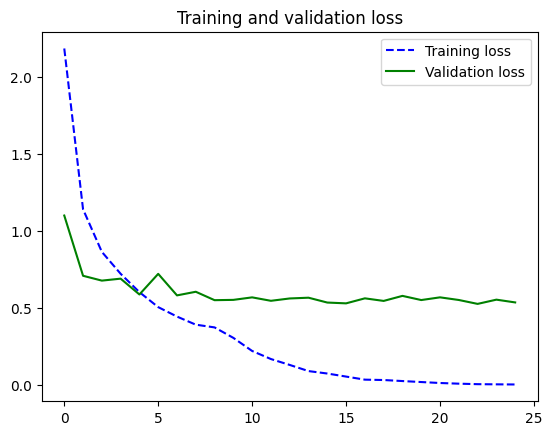

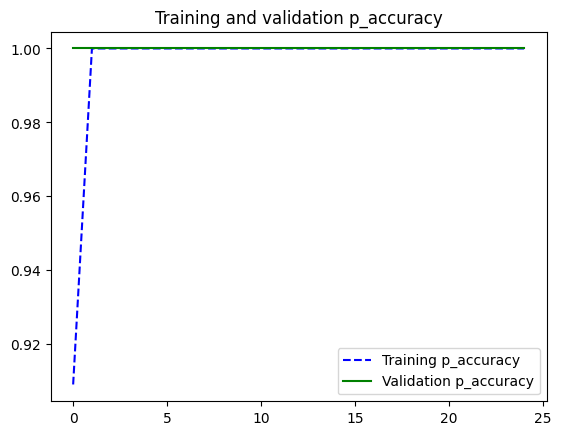

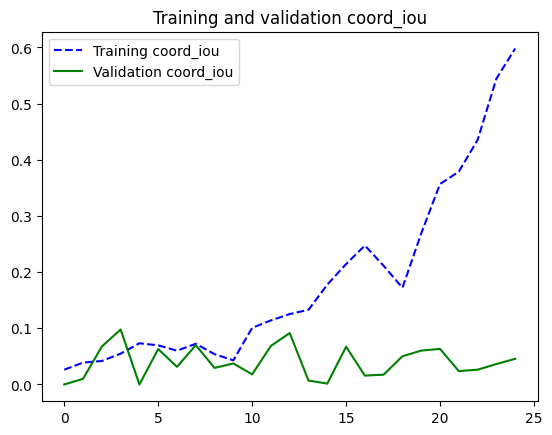

ValueError: math domain error

In [40]:

plot_training_analysis(history, 'loss')
plot_training_analysis(history, 'accuracy')
plot_training_analysis(history, 'iou')

y_pred = model.predict(x_test)
y_pred_reshape = np.concatenate((y_pred[0], y_pred[1]), axis=1)
class_res, accuracy = global_accuracy(y_test, y_pred_reshape)
print(f"Global accuracy: {accuracy:.2f}%")

for i in range(10):
    print_data_localisation(x_test, y_test, y_pred_reshape, image_size=IMAGE_SIZE, id=i)


In [43]:
def visualize_predictions(x_test, y_test, model, num_predictions=5):
  """Visualizes predictions with bounding boxes and probabilities."""

  if x_test.shape[0] == 0:
        raise ValueError("x_test est vide. Assurez-vous que les données de test sont correctement chargées.")
  if y_test.shape[0] == 0:
        raise ValueError("y_test est vide. Assurez-vous que les labels de test sont correctement chargés.")
  if num_predictions > x_test.shape[0]:
        raise ValueError(f"num_predictions ({num_predictions}) dépasse le nombre d'images disponibles ({x_test.shape[0]}).")



  y_pred = model.predict(x_test, verbose=0)  # Désactive la barre de progression
  y_pred_reshape = np.concatenate((y_pred[0], y_pred[1]), axis=1) # Concatenate predictions

  fig, axes = plt.subplots(1, num_predictions, figsize=(15, 5))

  for i in range(num_predictions):
      # Get the i-th test image and its ground truth bounding box
      image = x_test[i]
      true_box = y_test[i, 1:5]

      # Get the predicted bounding box
      pred_box = y_pred_reshape[i, 1:5]

      # Denormalize the bounding boxes
      true_box = true_box*y_std[1:5] + y_mean[1:5]
      pred_box = pred_box * y_std[1:5] + y_mean[1:5]

      # Calculate the coordinates of the bounding boxes
      ax = axes[i]
      ax.imshow(image)
      ax.set_title(f"Prediction {i+1}")
      ax.axis('off')  # Hide axis ticks

      # Plot ground truth box (optional)
      #rect_true = patches.Rectangle((true_box[0] - true_box[2]/2, true_box[1] - true_box[3]/2), true_box[2], true_box[3], linewidth=1, edgecolor='g', facecolor='none')
      #ax.add_patch(rect_true)

      # Plot predicted box
      rect_pred = patches.Rectangle((pred_box[0] - pred_box[2]/2, pred_box[1] - pred_box[3]/2), pred_box[2], pred_box[3], linewidth=1, edgecolor='r', facecolor='none')
      ax.add_patch(rect_pred)

      # Display probability score (optional)
      #score = y_pred_reshape[i, 0]
      #ax.text(0.05, 0.95, f"Score: {score:.2f}", color='r', transform=ax.transAxes)

  plt.show()

visualize_predictions(x_test, y_test, model) # Pass the model to the function


ValueError: x_test est vide. Assurez-vous que les données de test sont correctement chargées.